In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
import datetime

In [2]:
data = np.loadtxt(open("../data/sds_galaxy.txt", 'rb'), usecols=range(4))

# This is how we pull out the data from columns in the array.

# They put the data in Angstroms, lets use nano-meters instead, 1 Angstrom = 0.1 nm. 
wavelength = data[:,0] / 10.
flux = data[:,1]
best_fit = data[:,2]
sky_flux = data[:,3]

FWIW, the "flux" is actually the amount of energy arriving in a narrow wavelength band, per area, per time, and is given in units of $\frac{{\rm erg}}{{\rm cm}^{2}s^{1}{{\rm angstrom}}^{1}}$.  Let's be a bit snarky and call those "archaic units".  

In short you can think of it as the amount of energy coming in from light of a given wavelength.

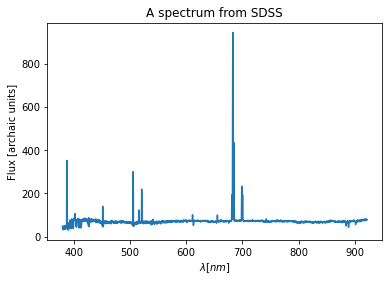

In [3]:
_ = plt.plot(wavelength, best_fit)
_ = plt.xlabel(r"$\lambda [nm]$")
_ = plt.ylabel("Flux [archaic units]")
_ = plt.title("A spectrum from SDSS")

In [4]:
peak_idx = np.argmax(flux)
peak_wl = wavelength[peak_idx]
print("The peak wavelength is %0.2f nm" % peak_wl)
(peak_wl / 656.28 ) - 1             

The peak wavelength is 682.97 nm


0.040664502956055504

In [5]:
cutout_wl = wavelength[peak_idx-50:peak_idx+50]
cutout_flux = flux[peak_idx-50:peak_idx+50]

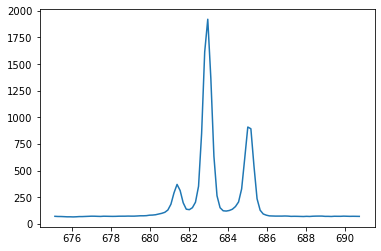

In [6]:
_ = plt.plot(cutout_wl, cutout_flux)

In [7]:
mask = (wavelength > 5000) & (wavelength < 5100)

In [8]:
cutout_wl = wavelength[mask]
cutout_flux = flux[mask]

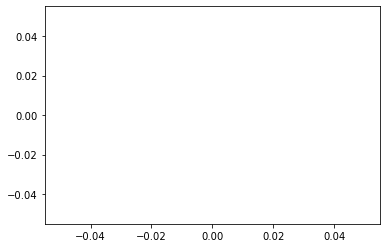

In [9]:
_ = plt.plot(cutout_wl, cutout_flux)

In [10]:
from functools import partial

def Gauss(x, prefact, mu, sigma):
    return prefact*stats.norm(loc=mu, scale=sigma).pdf(x)

def poly1(x, offset, slope):
    return offset + x*slope

def model_func(x, prefact, mu, sigma, offset, slope):
    return Gauss(x, prefact, mu, sigma) + poly1(x, offset, slope)

def generic_chi2(params, data_vals, model, x):
    model_vals = model(x, *params)
    return np.sum((data_vals - model_vals)**2)

def cost_func(data_vals, model, x):
    return partial(generic_chi2, data_vals=data_vals, model=model, x=x)

    

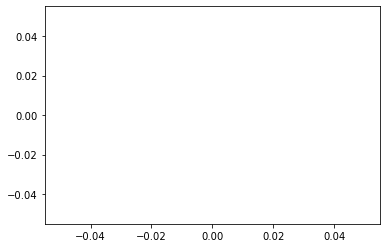

In [11]:
prefact_0 = 2400.
mu_0 = 5058
sigma_0 = 2.5
offset_0 = 60
slope_0 = 0

init_pars = (prefact_0, mu_0, sigma_0, offset_0, slope_0)

model_vals = model_func(cutout_wl, *init_pars)

_ = plt.plot(cutout_wl, cutout_flux)
_ = plt.plot(cutout_wl, model_vals)


In [12]:
our_chi2_func = cost_func(cutout_flux, model_func, cutout_wl)

In [39]:
our_chi2_func(init_pars)

102756.23823938092

In [40]:
result = optimize.minimize(our_chi2_func, x0=np.array(init_pars))
fit_pars = result['x']
model_fit = model_func(cutout_wl, *fit_pars)

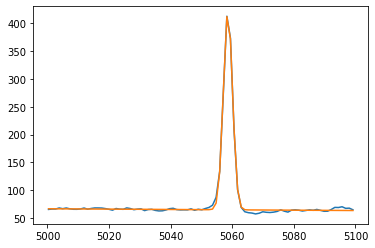

In [41]:
_ = plt.plot(cutout_wl, cutout_flux)
_ = plt.plot(cutout_wl, model_fit)


In [42]:
bad_chi2_func = cost_func(cutout_flux, Gauss, cutout_wl)

      fun: nan
 hess_inv: array([[ 1.00000015e+00,  3.49146746e-04,  1.37768930e-04],
       [ 3.49146746e-04,  1.18947287e-01, -3.23759959e-01],
       [ 1.37768930e-04, -3.23759959e-01,  8.81342248e-01]])
      jac: array([nan, nan, nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 452
      nit: 2
     njev: 113
   status: 2
  success: False
        x: array([  1903.17573328,  10365.43006735, -14461.48398353])


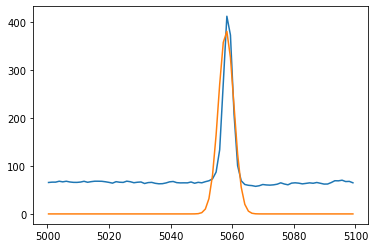

In [48]:
init_pars = (prefact_0, mu_0, sigma_0)

result_bad = optimize.minimize(bad_chi2_func, x0=np.array(init_pars_bad))

print(result_bad)

#fit_pars_bad = result_bad['x']
fit_pars_bad = init_pars
model_fit_bad = Gauss(cutout_wl, *fit_pars_bad)
_ = plt.plot(cutout_wl, cutout_flux)
_ = plt.plot(cutout_wl, model_fit_bad)


In [45]:
print(result_bad)

      fun: nan
 hess_inv: array([[ 1.00000015e+00,  3.49146746e-04,  1.37768930e-04],
       [ 3.49146746e-04,  1.18947287e-01, -3.23759959e-01],
       [ 1.37768930e-04, -3.23759959e-01,  8.81342248e-01]])
      jac: array([nan, nan, nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 452
      nit: 2
     njev: 113
   status: 2
  success: False
        x: array([  1903.17573328,  10365.43006735, -14461.48398353])


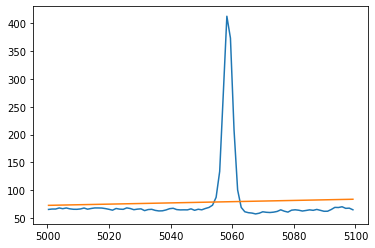

In [49]:
init_pars_bad_2 = (prefact_0, mu_0+20, sigma_0, offset_0, slope_0)

result_bad_2 = optimize.minimize(our_chi2_func, x0=np.array(init_pars_bad_2))
fit_pars_bad_2 = result_bad_2['x']
model_fit_bad_2 = model_func(cutout_wl, *fit_pars_bad_2)

_ = plt.plot(cutout_wl, cutout_flux)
_ = plt.plot(cutout_wl, model_fit_bad_2)
